In [1]:
import os,sys,string, time
import ROOT
from math import *
from ROOT import gPad, TTree, TObject, TFile, gDirectory, TH1D, TH2D, TH3D, TCanvas, gROOT, TGaxis, gStyle, TColor, TLegend, THStack, TChain, TLatex, TText, TCollection, kRed, kBlue
from array import array
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from root_pandas import read_root
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables

print ('Success')



Welcome to JupyROOT 6.24/06
Success


# Reading in .pkl files

In [2]:
HNL_masses = Constants.HNL_mass_samples #in MeV

Run = "run3" #so far either "run1" or "run3"

print(f"Loading {Run} pickles")

loc_pkls = f"pkl_files/{Run}/current_files/"

overlay_from_pkl = pd.read_pickle(loc_pkls+f"overlay_{Run}_Presel_vars1_unflattened.pkl")
#FLAT_overlay_from_pkl = pd.read_pickle(loc_pkls+"overlay_run1_Aditya_vars_flattened.pkl")
dirt_from_pkl = pd.read_pickle(loc_pkls+f"dirt_{Run}_Presel_vars1_unflattened.pkl")
EXT_from_pkl = pd.read_pickle(loc_pkls+f"EXT_{Run}_Presel_vars1_unflattened.pkl")

signal_samples_dict = {}
#signal_dfs_list = []

for HNL_mass in HNL_masses:
    signal_from_pkl = pd.read_pickle(loc_pkls+f"signal_{HNL_mass}MeV_{Run}_Presel_vars1_unflattened.pkl")
    signal_samples_dict[HNL_mass] = signal_from_pkl



print(f"Successfully loaded {Run} pkls")

print("Overlay .pkl is "+str(len(overlay_from_pkl))+" entries long.")
#print("Flat Overlay .pkl is "+str(len(FLAT_overlay_from_pkl))+" entries long.")
print("Dirt .pkl is "+str(len(dirt_from_pkl))+" entries long.")
print("EXT .pkl is "+str(len(EXT_from_pkl))+" entries long.")

for HNL_mass in HNL_masses:
    print(f"{HNL_mass}MeV Signal .pkl is "+str(len(signal_samples_dict[HNL_mass]))+" entries long.")



Loading run3 pickles
Successfully loaded run3 pkls
Overlay .pkl is 748702 entries long.
Dirt .pkl is 389264 entries long.
EXT .pkl is 3211097 entries long.
20MeV Signal .pkl is 44806 entries long.
50MeV Signal .pkl is 45383 entries long.
100MeV Signal .pkl is 44970 entries long.
150MeV Signal .pkl is 44843 entries long.
180MeV Signal .pkl is 45826 entries long.
200MeV Signal .pkl is 45003 entries long.


# Functions

In [3]:
#Defining functions
def Preselection_with_list(df_cut, cut_dict, Efficiency_list): #This only works for a conditional with one variable, NOT TRUE, key name doesn't matter?
    NumEvs = len(df_cut)
    for cut in cut_dict.keys():
        df_cut=df_cut.query(cut_dict[cut])
        Efficiency_list.append(len(df_cut)/NumEvs)
    Selected = df_cut.copy()
    return Selected
        
def Edit_Weight_Tune(df_to_Tune): #This is taken from Aditya's code, Owen also has the same in his for overlay and dirt, there is the same block in PELEE code
    df_to_Tune.loc[ df_to_Tune['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df_to_Tune.loc[ df_to_Tune['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df_to_Tune.loc[ df_to_Tune['weightSplineTimesTune'] > 50, 'weightSplineTimesTune' ] = 1.
    df_to_Tune.loc[ np.isnan(df_to_Tune['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.
    return df_to_Tune

def MC_weight_branch(df_MC): #Writes a new branch called "weight" including, ppfx, weightSplineTimesTune AND if pi0 are present, scales by pi0 factor
    df_MC["weight"] = df_MC["ppfx_cv"]*df_MC["weightSplineTimesTune"] 
    df_MC.loc[df_MC["npi0"]>0,"weight"] = df_MC["weight"][df_MC["npi0"]>0]*pi0_scaling_factor #If MC event contains pi0, need to scale down, derived from BNB data
    
def Plot_one_variable(signal, background, variable_name, numbins, range_lims=None, loghist=False):
    plt.figure(figsize=(12,8),facecolor='white')
    plot1 = plt.figure(1)
    plt.hist(signal[variable_name],bins=numbins,label="Signal",alpha=0.5, range=range_lims)
    plt.hist(background[variable_name],bins=numbins,label="Background",alpha=0.5, range=range_lims)
    if loghist == True:
        plt.yscale("log")
    else:
        plt.yscale("linear")
    plt.xlabel(variable_name)
    plt.ylabel('Number of events')
    plt.legend()

# Plotting variables before preselection

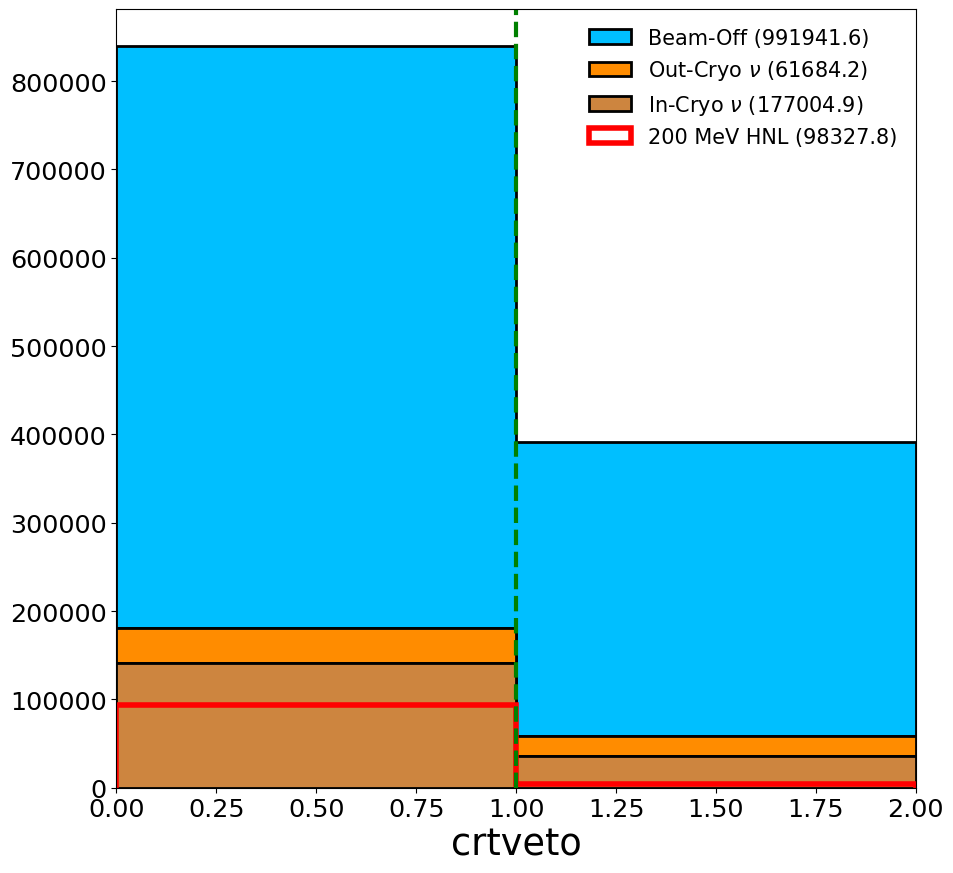

In [29]:
#Want to have arrows drawn on for where the preselection cut goes
HNL_mass = 200 #only plotting one at a time
variable = "crtveto"
samples = {"overlay":overlay_from_pkl,
           "dirtoverlay":dirt_from_pkl,
           "beamoff":EXT_from_pkl,
           "signal":signal_samples_dict[HNL_mass]}
samples.update(signal_samples_dict)
if Run == "run1":
    sample_norms = {"overlay":Constants.SF_overlay_run1,
           "dirtoverlay":Constants.SF_dirt_run1,
           "beamoff":Constants.SF_EXT_run1,
           "signal":Constants.run1_POT_scaling_dict[HNL_mass]}
elif Run == "run3":
    sample_norms = {"overlay":Constants.SF_overlay_run3,
           "dirtoverlay":Constants.SF_dirt_run3,
           "beamoff":Constants.SF_EXT_run3,
           "signal":Constants.run3_POT_scaling_dict[HNL_mass]}
PT.Plot_preselection_variable(variable, samples, sample_norms, xlabel=[],xlims=[0,2],bins=2, HNL_mass=HNL_mass,HNLplotscale=30000,cutline=1.0)
# plt.axvline(x=16.5, lw=3, color='green', linestyle = 'dashed')

#plt.savefig("plots/Preselection_variables/" + Run + "_" + str(HNL_mass) + "_MeV_" + str(variable)+".png")
#PT.Plot_preselection_variable("bdt_ext", samples, sample_norms, xlabel=[],xlims=[0,2],bins=50,figsize=[8,8],HNLplotscale=1000000,logy="False")

## Plot only signal samples before preselection

In [4]:
#Need a new plotting function for this
print(overlay_from_pkl.keys())
print()
print(EXT_from_pkl.keys())

Index(['nslice', 'flash_time', 'nu_flashmatch_score', 'NeutrinoEnergy2',
       'contained_fraction', 'trk_score', 'trk_score_v', 'n_pfps', 'crtveto',
       'weightSplineTimesTune', 'ppfx_cv', 'npi0', 'weight'],
      dtype='object')

Index(['nslice', 'flash_time', 'nu_flashmatch_score', 'NeutrinoEnergy2',
       'contained_fraction', 'trk_score', 'trk_score_v', 'n_pfps', 'crtveto'],
      dtype='object')


# Pre-selection cuts

In [5]:
#Make cuts on signal
if Run == "run1": 
    #Preselection_dict = Constants.Preselection_dict #Have also saved this in Constants.py, it is also here in case I want to add to or edit the cuts
    Preselection_dict = Constants.Preselection_dict_for_plot
elif Run == "run3":
    #Preselection_dict = Constants.Preselection_dict
    Preselection_dict = Constants.Preselection_dict_for_plot
    Preselection_dict.update(Constants.Preselection_dict_crtveto) #Adding crtveto cut
    
print("Preselection is:" + "\n")
print(Preselection_dict)
print()
#Should add a cut on total track+shower multiplicity (n_pfps)

#"Containment":""
#"n_track":"n_track < 5"
#"shr_energy_tot":"shr_energy_tot < 1.0"
#"trk_len":"trk_len < 50.0"

#print(Signal_run1.numentries)
print("Numbers of rows in dataframes BEFORE Preselection:")
print("Overlay file has " + str(len(overlay_from_pkl)))
print("Dirt file has " + str(len(dirt_from_pkl)))
print("EXT file has " + str(len(EXT_from_pkl)))
#print(len(signal_from_pkl))


Preselection is:

{'nslice': 'nslice==1', 'flash_time': 'flash_time > 6.55 and flash_time < 16.5', 'nu_flashmatch_score': 'nu_flashmatch_score < 15', 'NeutrinoEnergy2': 'NeutrinoEnergy2 < 500', 'contained_fraction': 'contained_fraction > 0.9', 'trk_score': 'trk_score < 0.97', 'n_pfps': 'n_pfps < 6', 'crtveto': 'crtveto==0'}

Numbers of rows in dataframes BEFORE Preselection:
Overlay file has 748702
Dirt file has 389264
EXT file has 3211097


In [6]:
#Make cuts on bkg
Preselection_efficiency_overlay = [1.0]
Preselection_efficiency_dirt = [1.0]
Preselection_efficiency_EXT = [1.0]

Preselection_signal_max = []
Preselection_signal_min = []

#Preselection_efficiency_signal = [1.0]
Preselection_efficiency_signal_dict = {}
for HNL_mass in HNL_masses:
    Preselection_efficiency_signal_dict[HNL_mass] = [1.0]

Selected_signal_from_pkl_dict = {}

    
Selected_overlay_from_pkl = Preselection_with_list(overlay_from_pkl, Preselection_dict, Preselection_efficiency_overlay)
Selected_dirt_from_pkl = Preselection_with_list(dirt_from_pkl, Preselection_dict, Preselection_efficiency_dirt)
Selected_EXT_from_pkl = Preselection_with_list(EXT_from_pkl, Preselection_dict, Preselection_efficiency_EXT)
#Selected_signal_from_pkl = Preselection_with_list(signal_from_pkl, Preselection_dict, Preselection_efficiency_signal)

for HNL_mass in HNL_masses:
    Selected_signal_from_pkl_dict[HNL_mass] = Preselection_with_list(signal_samples_dict[HNL_mass], Preselection_dict, Preselection_efficiency_signal_dict[HNL_mass])

print("AFTER Preselection:")
print("Overlay .pkl is "+str(len(Selected_overlay_from_pkl))+" entries long.")
print("Dirt .pkl is "+str(len(Selected_dirt_from_pkl))+" entries long.")
print("EXT .pkl is "+str(len(Selected_EXT_from_pkl))+" entries long.")

for HNL_mass in HNL_masses:
    print(f"{HNL_mass}MeV Signal .pkl is "+str(len(Selected_signal_from_pkl_dict[HNL_mass]))+" entries long.")


AFTER Preselection:
Overlay .pkl is 24046 entries long.
Dirt .pkl is 3107 entries long.
EXT .pkl is 11591 entries long.
20MeV Signal .pkl is 16941 entries long.
50MeV Signal .pkl is 16011 entries long.
100MeV Signal .pkl is 16170 entries long.
150MeV Signal .pkl is 17175 entries long.
180MeV Signal .pkl is 15620 entries long.
200MeV Signal .pkl is 15141 entries long.


In [7]:
#Working out the maximum and minimum efficiencies
Preselection_signal_max = []
Preselection_signal_min = []

max_presel_effic = 0.0
min_presel_effic = 1.0
for i in range(len(Preselection_dict)+1):
    for HNL_mass in HNL_masses:
        if Preselection_efficiency_signal_dict[HNL_mass][i] > max_presel_effic:
            max_presel_effic = Preselection_efficiency_signal_dict[HNL_mass][i]
        if Preselection_efficiency_signal_dict[HNL_mass][i] < min_presel_effic:
            min_presel_effic = Preselection_efficiency_signal_dict[HNL_mass][i]
    Preselection_signal_max.append(max_presel_effic)
    Preselection_signal_min.append(min_presel_effic)
    max_presel_effic = 0.0

In [8]:
print(Preselection_signal_max)
print(Preselection_signal_min)

[1.0, 0.6078188721698776, 0.5889467022922233, 0.5469835466179159, 0.5444241316270567, 0.4045844466319786, 0.3936155252425819, 0.3927155111798622]
[1.0, 0.5331732806100833, 0.5153226945346703, 0.4775031775172998, 0.4749611636774467, 0.3506849315068493, 0.3425222426210987, 0.34156192628159865]


# Save pkls

In [15]:
print_vals = input("Do you want to save the pickle files? y/n ")
if print_vals == "y":
    loc_pkls = f"pkl_files/{Run}/current_files/"

    print(f"Saving {Run} Preselected overlay .pkl")
    Selected_overlay_from_pkl.to_pickle(loc_pkls+f"Preselected_overlay_{Run}_my_vars_flattened.pkl")

    print(f"Saving {Run} Preselected dirt .pkl")
    Selected_dirt_from_pkl.to_pickle(loc_pkls+f"Preselected_dirt_{Run}_my_vars_flattened.pkl")

    print(f"Saving {Run} Preselected EXT .pkl")
    Selected_EXT_from_pkl.to_pickle(loc_pkls+f"Preselected_EXT_{Run}_my_vars_flattened.pkl")
    for HNL_mass in HNL_masses:
        print(f"Saving {Run} Preselected {HNL_mass}MeV signal .pkl")
        Selected_signal_from_pkl_dict[HNL_mass].to_pickle(loc_pkls+f"Preselected_signal_{HNL_mass}MeV_{Run}_my_vars_flattened.pkl")
else:
    print("Not saving pickle files, move onto next cell")

Saving run3 Preselected overlay .pkl
Saving run3 Preselected dirt .pkl
Saving run3 Preselected EXT .pkl
Saving run3 Preselected 20MeV signal .pkl
Saving run3 Preselected 50MeV signal .pkl
Saving run3 Preselected 100MeV signal .pkl
Saving run3 Preselected 150MeV signal .pkl
Saving run3 Preselected 180MeV signal .pkl
Saving run3 Preselected 200MeV signal .pkl


# Plotting Efficiencies

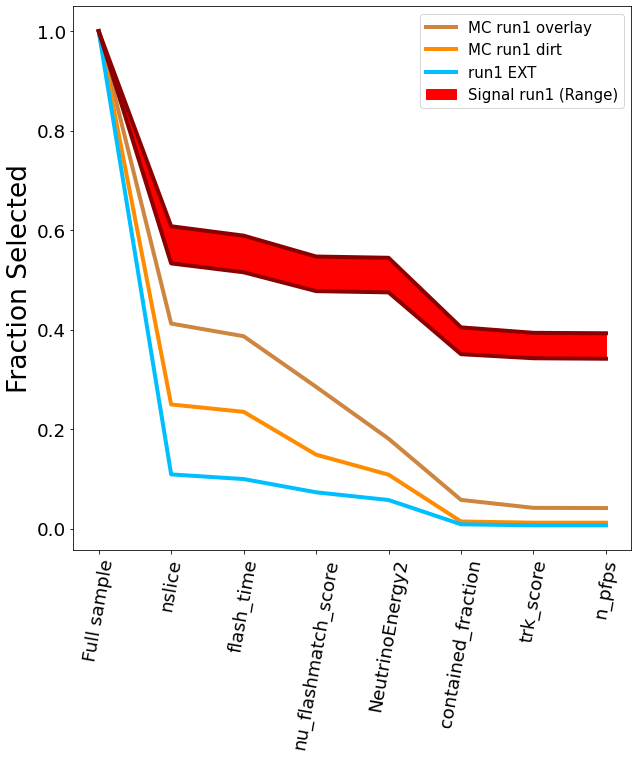

In [9]:
#Signal-only efficiencies
plt.figure(figsize=[10,10])
#print(Preselection_efficiency_signal_dict)
#print(len(Preselection_efficiency_signal_dict[HNL_mass]))
# for HNL_mass in HNL_masses:
#     plt.plot(np.array(range(1, len(Preselection_efficiency_signal_dict[HNL_mass])+1)), Preselection_efficiency_signal_dict[HNL_mass], label=f"{HNL_mass} MeV HNL",lw=4,markersize=15)
#plt.plot(np.array(range(1, len(Preselection_efficiency_overlay)+1)),Preselection_efficiency_signal,label="100 MeV HNL",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Preselection_efficiency_overlay)+1)),Preselection_efficiency_overlay,label=f"MC {Run} overlay",color='peru',lw=4,markersize=15)
plt.plot(np.array(range(1, len(Preselection_efficiency_overlay)+1)),Preselection_efficiency_dirt,label=f"MC {Run} dirt",color="darkorange",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Preselection_efficiency_overlay)+1)),Preselection_efficiency_EXT,label=f"{Run} EXT",color='deepskyblue',lw=4,markersize=15)
plt.plot(np.array(range(1, len(Preselection_efficiency_signal_dict[HNL_mass])+1)),Preselection_signal_max,color="darkred",lw=4,marker="")
plt.plot(np.array(range(1, len(Preselection_efficiency_signal_dict[HNL_mass])+1)),Preselection_signal_min,color="darkred",lw=4,marker="")
plt.fill_between(np.array(range(1, len(Preselection_efficiency_signal_dict[HNL_mass])+1)),Preselection_signal_min,Preselection_signal_max,label=f"Signal {Run} (Range)",color="red")
plt.ylabel("Fraction Selected")
plt.xticks(np.array(range(1, len(Preselection_efficiency_signal_dict[HNL_mass])+1)),["Full sample"]+list(Preselection_dict.keys()),rotation=80)
#plt.yscale("log")
plt.legend()

#print(Preselection_efficiency_signal)

[1.0, 0.5580340693291006, 0.542388254301182, 0.49757659930274084, 0.4948839318613418, 0.37113460502820217, 0.36614608429466283]


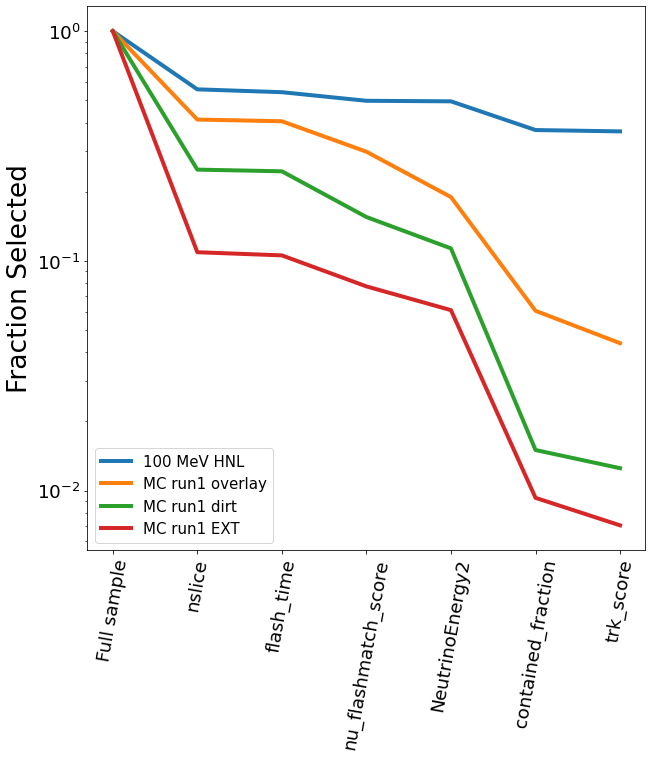

In [15]:
#Plotting efficiency
plt.figure(figsize=[10,10])
plt.plot(np.array(range(1, len(Preselection_efficiency_signal)+1)),Preselection_efficiency_signal,label="100 MeV HNL",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Preselection_efficiency_signal)+1)),Preselection_efficiency_overlay,label="MC run1 overlay",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Preselection_efficiency_signal)+1)),Preselection_efficiency_dirt,label="MC run1 dirt",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Preselection_efficiency_signal)+1)),Preselection_efficiency_EXT,label="MC run1 EXT",lw=4,markersize=15)
plt.ylabel("Fraction Selected")
plt.xticks(np.array(range(1, len(Preselection_efficiency_signal)+1)),["Full sample"]+list(Preselection_dict.keys()),rotation=80)
#plt.yscale("log")
plt.legend()

print(Preselection_efficiency_signal)


# Testing code

In [ ]:
#Testing what the variables look like
variable = "dvtx_x_boundary"
def test_variables(df):
    test_signal = df[variable]
    print(type(test_signal))
    print(len(test_signal))
test_variables(df_overlay_run1)
test_variables(df_dirt_run1)
test_variables(df_EXT_run1)
test_variables(df_signal_run1)

In [ ]:
#Single variables
plt.rcParams.update({'font.size': 22})

plot_variable = "n_showers"
range_list=[0,10]

Plot_one_variable(df_signal_run1, df_overlay_run1, plot_variable, 10, range_list, False) #With range
#Plot_one_variable(df_signal_run1, df_NuMI_MC_overlay_pdra_run1, plot_variable, None, loghist=False) #Without range

In [ ]:
#print(overlay_from_pkl['nslice'])
#print("Flat Overlay .pkl is "+str(len(FLAT_overlay_from_pkl))+" entries long.")

print("-----Unflattened-----")
unique_var = overlay_from_pkl["nslice"].unique()
print(unique_var)
unique_var = overlay_from_pkl["n_pfps"].unique()
print(unique_var)
print(overlay_from_pkl["n_pfps"])
print(type(overlay_from_pkl["n_pfps"][0]))

# for var in overlay_from_pkl.keys():
#     if type(overlay_from_pkl[var][1]) == "numpy.ndarray":
#         print(var)

# print("-----Flattened-----")
# unique_var = FLAT_overlay_from_pkl["nslice"].unique()
# print(unique_var)
# unique_var = FLAT_overlay_from_pkl["n_pfps"].unique()
# print(unique_var)
# print(FLAT_overlay_from_pkl["n_pfps"])
# print(type(FLAT_overlay_from_pkl["n_pfps"]))